# Проект: классификация

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import optuna

%matplotlib inline
colors = sns.color_palette("Set1")
order_colors = [colors[2], colors[0]] + [color for i, color in enumerate(colors) if i not in [0, 2]]
sns.set_theme('notebook', style="whitegrid", palette=order_colors)

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [5]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')

In [6]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = (
    df['balance'].str.strip(" $").str.replace(" ", "").str.replace(",", ".")
).astype('float')

print(f'{df["balance"].mean():.3f}')

1529.129


### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
print(f'{df["balance"].mean():.3f}')

1526.936


### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
mask_1 = df['job'].value_counts().index[0]
mask_2 = df['education'].value_counts().index[0]
df['job'] = df['job'].apply(lambda x: mask_1 if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: mask_2 if x == 'unknown'else x)

filtered_df = df[(df['job'] == mask_1) & (df['education'] == mask_2)]
print(f"{filtered_df['balance'].mean():.3f}")

1598.883


### Задание 6

In [11]:
# удалите все выбросы для признака balance
# ваш код
q1 = np.percentile(df['balance'], 25)
q3 = np.percentile(df['balance'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

In [12]:
df.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

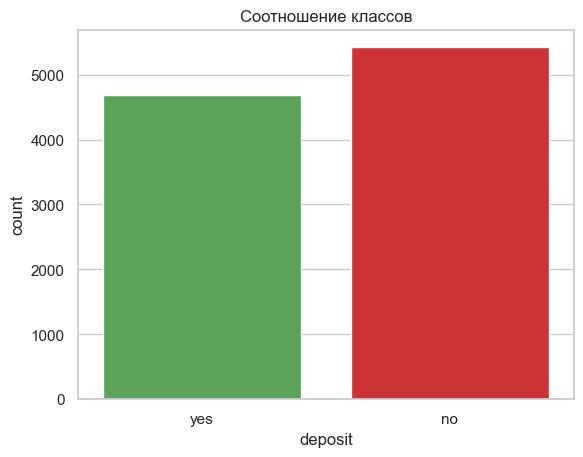

In [13]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
ax = sns.countplot(data=df, x='deposit')
ax.set_title('Соотношение классов');
df['deposit'].value_counts()

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


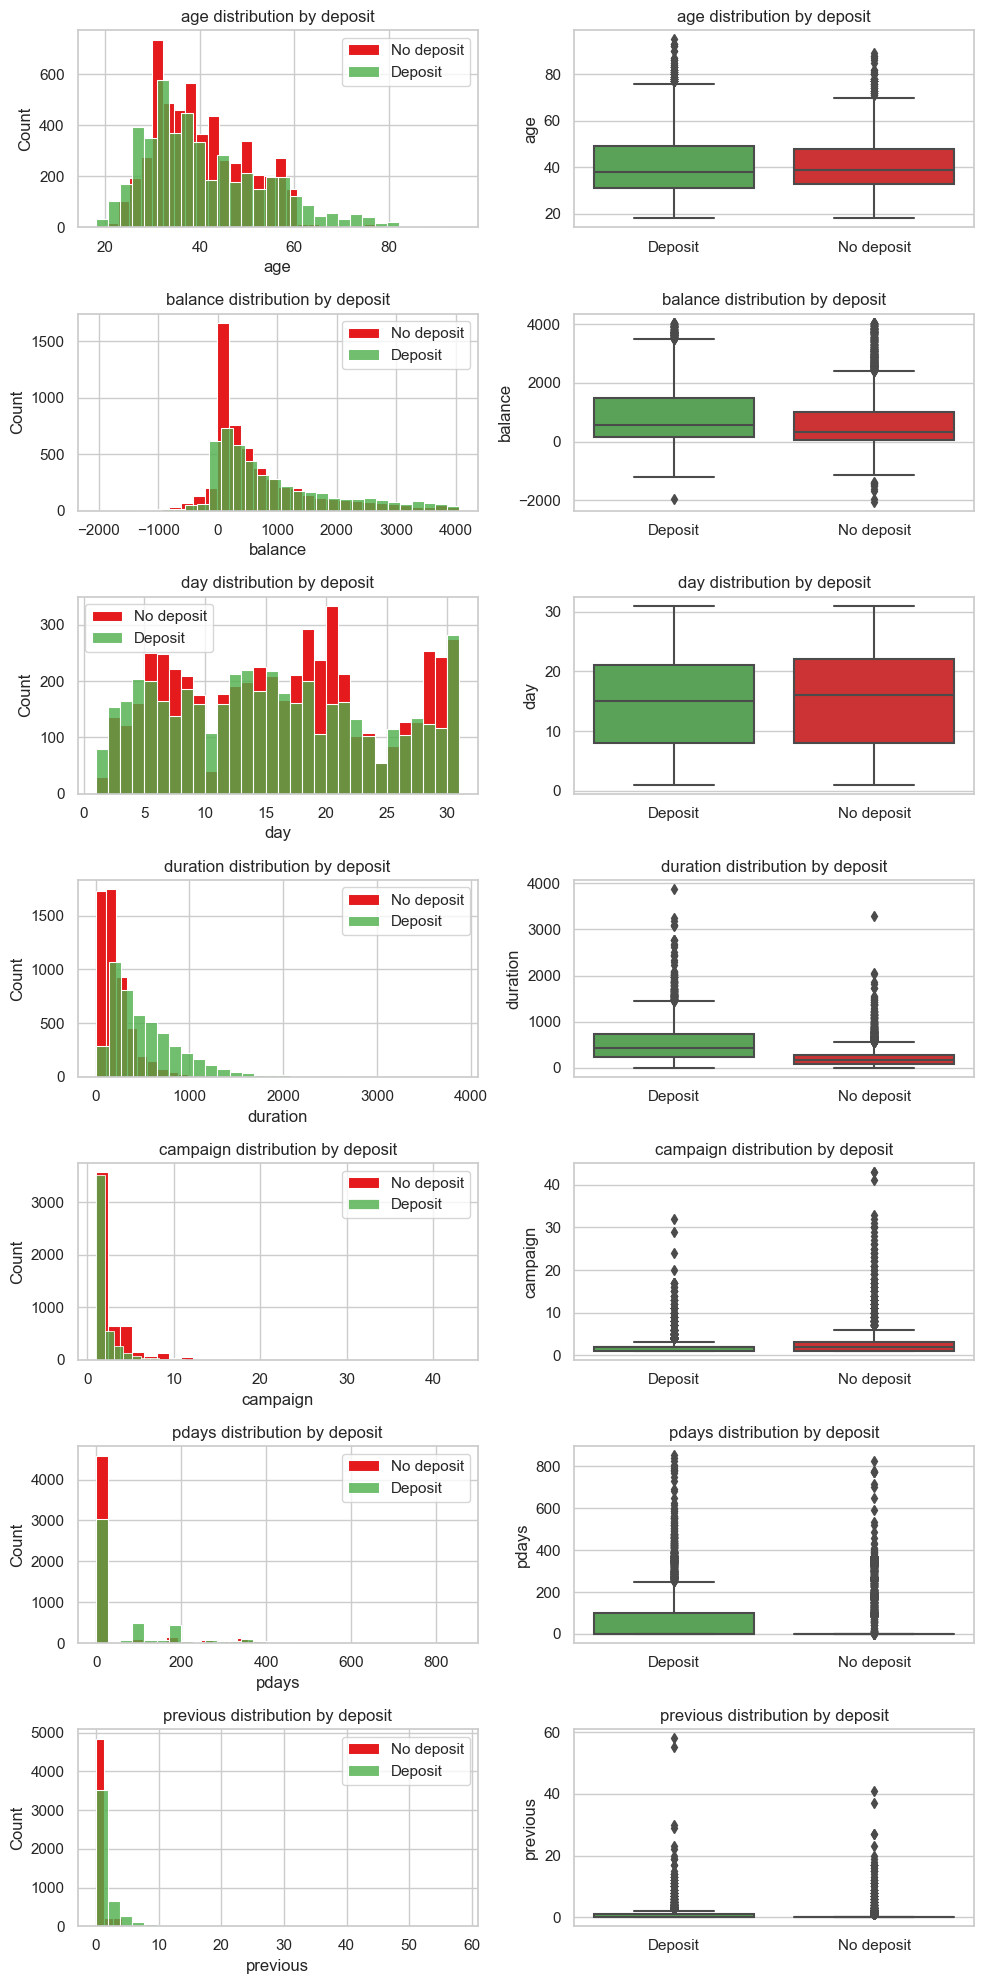

In [14]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
num_features = [col for col in df.select_dtypes(include=['number']).columns]

# Создаем фигуру с подграфиками
n = len(num_features)
fig, axes = plt.subplots(n, 2, figsize=(10, 20))

for i, feature in enumerate(num_features):
    # Без депозита
    histplot = sns.histplot(
        data=df[df['deposit'] == 'no'], x=feature, ax=axes[i][0], bins=30,
        alpha=1, label='No deposit', color=sns.color_palette()[1])
    # С депозитом
    histplot = sns.histplot(
        data=df[df['deposit'] == 'yes'], x=feature, ax=axes[i][0], bins=30,
        alpha=0.8, label='Deposit', color=sns.color_palette()[0])
    histplot.set_title(f'{feature} distribution by deposit')
    histplot.legend()

    # Боксплот рядом
    boxplot = sns.boxplot(
        data=df, x='deposit', y=feature, ax=axes[i][1])
    boxplot.set_title(f'{feature} distribution by deposit')
    boxplot.set_xlabel('')
    boxplot.set_xticklabels(['Deposit', 'No deposit'])
plt.tight_layout();

df[num_features].describe()

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


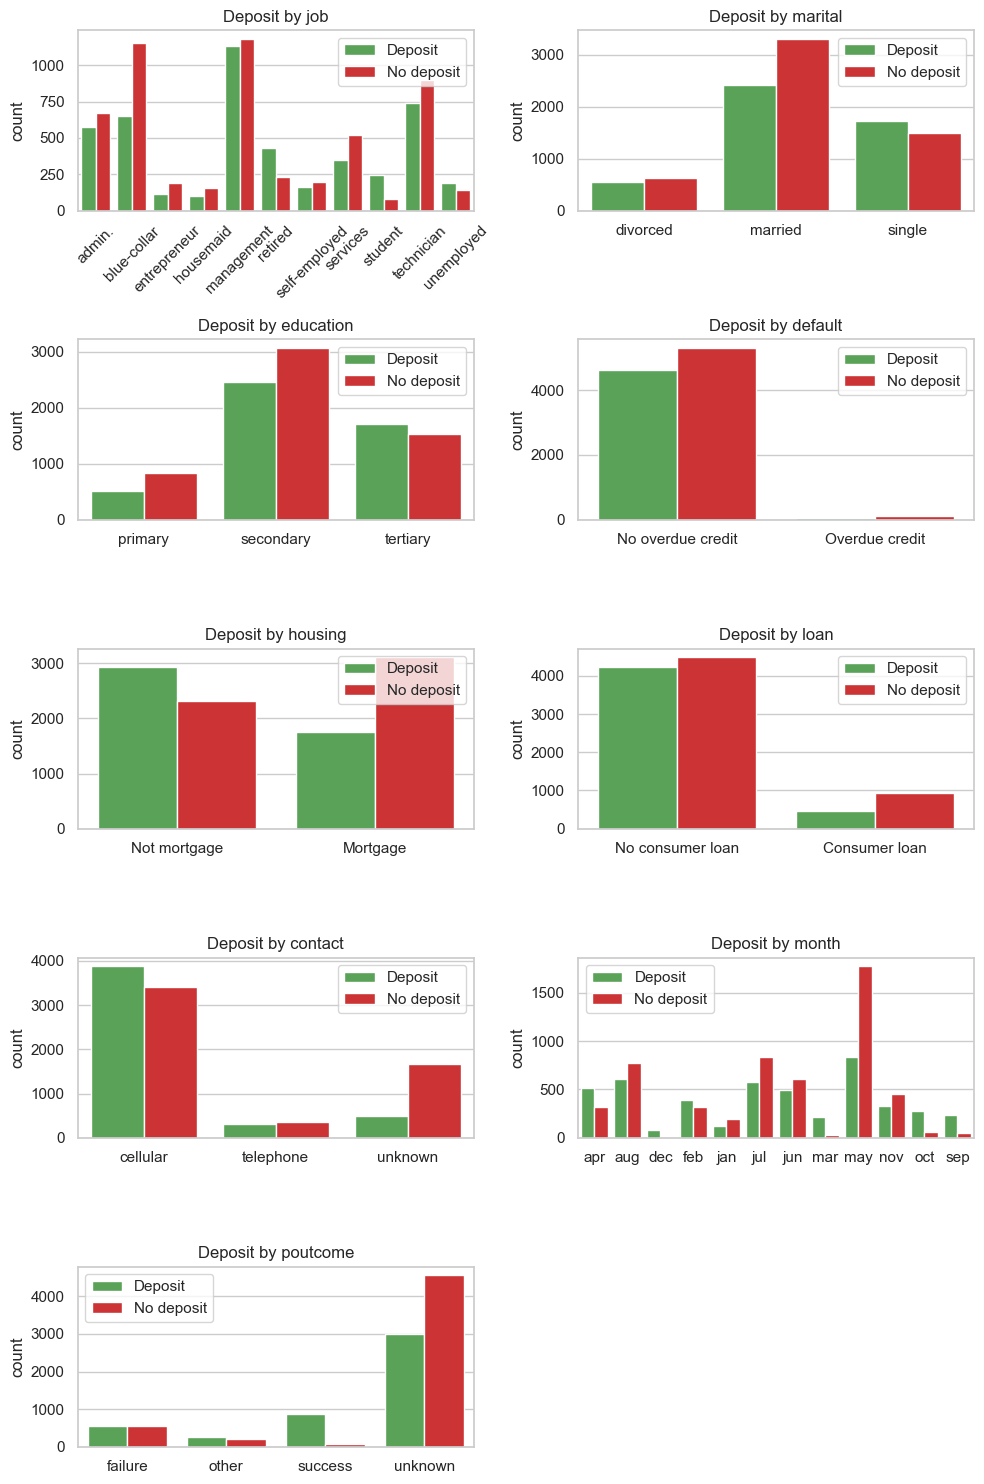

In [15]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
cat_features = [col for col in df.select_dtypes(include=['object']).columns if col != 'deposit']

# Создаем фигуру с подграфиками для категориальных
n = len(cat_features) // 2
fig, axes = plt.subplots(n+1, 2, figsize=(10, 15))
axes = axes.flatten()
for i, feature in enumerate(cat_features):
    feature_counts = df.groupby(feature)['deposit'].value_counts().reset_index(name='count')
    feature_counts['deposit'] = feature_counts['deposit'].replace(
        {'no' : 'No deposit', 'yes' : 'Deposit'}
    )
    
    if feature == 'default':
        feature_counts[feature] = feature_counts[feature].replace(
            {'no': 'No overdue credit', 'yes': 'Overdue credit'}
        )
    elif feature == 'housing':
        feature_counts[feature] = feature_counts[feature].replace(
            {'no': 'Not mortgage', 'yes': 'Mortgage'}
        )
    elif feature == 'loan':
        feature_counts[feature] = feature_counts[feature].replace(
            {'no': 'No сonsumer loan', 'yes': 'Сonsumer loan'}
        )
    
    # Построение графика
    barplot = sns.barplot(
        data=feature_counts, x=feature, y='count', hue='deposit', 
        hue_order=['Deposit', 'No deposit'], ax=axes[i])
    barplot.set_title(f'Deposit by {feature}')
    barplot.legend()
    barplot.set_xlabel('')
    if feature == 'job':
        barplot.tick_params(axis='x', rotation=45)
    axes[9].set_visible(False)
plt.tight_layout()

df[cat_features].describe()

In [16]:
result = df.groupby('poutcome')['deposit'].value_counts(normalize=True).unstack()
print(result)

deposit         no       yes
poutcome                    
failure   0.506763  0.493237
other     0.449064  0.550936
success   0.088889  0.911111
unknown   0.602642  0.397358


### Задание 6

In [17]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
poutcome_stats = df.groupby('poutcome')['deposit'].value_counts(normalize=True).unstack()
print(round(poutcome_stats * 100, 2))

deposit      no    yes
poutcome              
failure   50.68  49.32
other     44.91  55.09
success    8.89  91.11
unknown   60.26  39.74


### Задание 7

In [18]:
month_stats = df.groupby('month')['deposit'].value_counts(normalize=True).unstack()
month_stats_sorted = month_stats.sort_values('no', ascending=False)
print(round(month_stats_sorted[['no', 'yes']] * 100, 2))

deposit     no    yes
month                
may      67.86  32.14
jan      60.82  39.18
jul      58.96  41.04
nov      58.46  41.54
aug      55.96  44.04
jun      54.89  45.11
feb      45.56  54.44
apr      38.19  61.81
oct      18.51  81.49
sep      16.55  83.45
mar      10.13  89.87
dec       9.68  90.32


In [19]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
month_stats = df.groupby('month')['deposit'].value_counts(normalize=True)
print(round(month_stats * 100, 2))

month  deposit
apr    yes        61.81
       no         38.19
aug    no         55.96
       yes        44.04
dec    yes        90.32
       no          9.68
feb    yes        54.44
       no         45.56
jan    no         60.82
       yes        39.18
jul    no         58.96
       yes        41.04
jun    no         54.89
       yes        45.11
mar    yes        89.87
       no         10.13
may    no         67.86
       yes        32.14
nov    no         58.46
       yes        41.54
oct    yes        81.49
       no         18.51
sep    yes        83.45
       no         16.55
Name: proportion, dtype: float64


### Задание 8

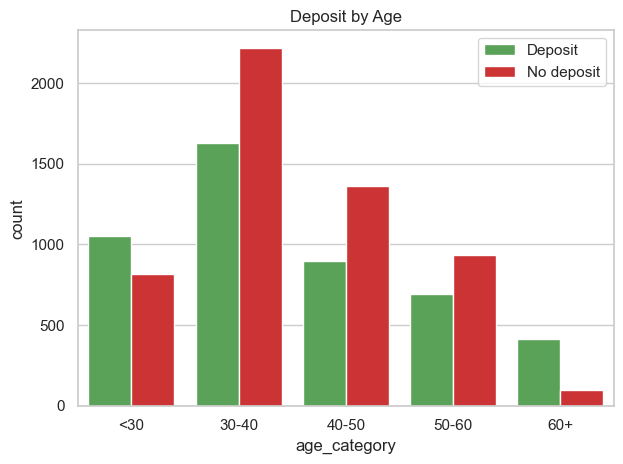

In [20]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_category'] = pd.cut(df['age'], 
                         bins=[0, 30, 40, 50, 60, 100], 
                         labels=['<30', '30-40', '40-50', '50-60', '60+'])

# Визуализация
age_counts = df.groupby('age_category')['deposit'].value_counts().reset_index(name='count')
age_counts['deposit'].replace({'no' : 'No deposit', 'yes' : 'Deposit'}, inplace=True)
barplot = sns.barplot(
        data=age_counts, x='age_category', y='count', hue='deposit')
barplot.set_title(f'Deposit by Age')
barplot.legend()

plt.tight_layout()

### Задания 9 и 10

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
# диаграммы в задании 4, 5

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
# диаграммы в задании 4, 5

In [23]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
# диаграммы в задании 4, 5

### Задание 11

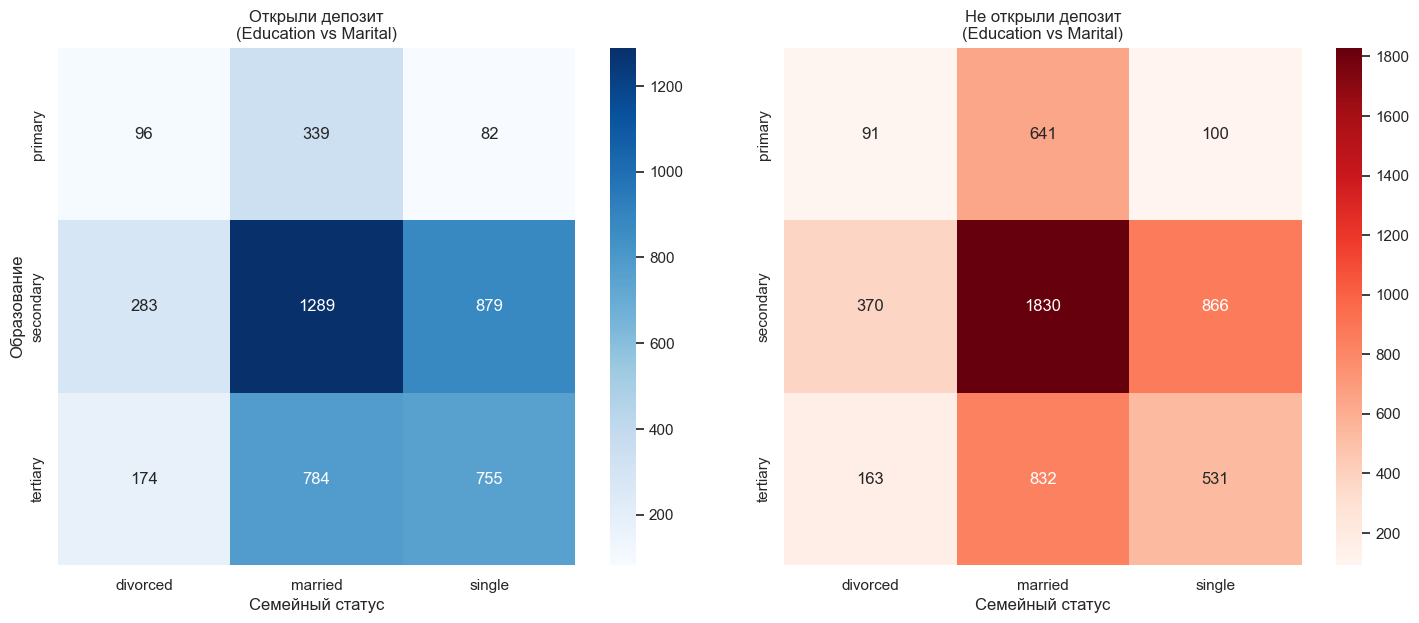

In [24]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Разделяем данные
df_deposit = df[df['deposit'] == 'yes']
df_no_deposit = df[df['deposit'] == 'no']

# Создаем сводные таблицы
pivot_yes = pd.crosstab(df_deposit['education'], df_deposit['marital'])
pivot_no = pd.crosstab(df_no_deposit['education'], df_no_deposit['marital'])

# Тепловые карты
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(pivot_yes, annot=True, fmt='g', cmap='Blues', square=True, ax=ax1)
ax1.set_title('Открыли депозит\n(Education vs Marital)')
ax1.set_ylabel('Образование')
ax1.set_xlabel('Семейный статус')

sns.heatmap(pivot_no, annot=True, fmt='g', cmap='Reds', square=True, ax=ax2)
ax2.set_title('Не открыли депозит\n(Education vs Marital)')
ax2.set_ylabel('')
ax2.set_xlabel('Семейный статус')

plt.tight_layout()

## Часть 3: преобразование данных

### Задание 1

In [25]:
# преобразуйте уровни образования
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
education = le.classes_
df['education'].sum()

11995

In [26]:
# Ранее мы создали порядковую переменную для возраста.
# Обработайте её по такому же принципу, чтобы её можно
# было использовать при обучении модели.
le = LabelEncoder()
df['age_category'] = le.fit_transform(df['age_category'])
age = le.classes_

### Задания 2 и 3

In [27]:
# преобразуйте бинарные переменные в представление из нулей и единиц
binary_cols = ['deposit', 'default', 'housing', 'loan']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0}).astype('int8')

In [28]:
print(df['deposit'].std().round(3))
print(round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3))

0.499
0.635


### Задание 4

In [29]:
# создайте дамми-переменные
cat_cols = ['job', 'marital', 'contact', 'month', 'poutcome']
dummies_df = pd.get_dummies(df[cat_cols])
df = pd.concat([df, dummies_df], axis=1)
df.shape

(10105, 51)

In [30]:
df.drop(cat_cols, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int8   
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int8   
 5   loan               10105 non-null  int8   
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int8   
 12  age_category       10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задания 5 и 6

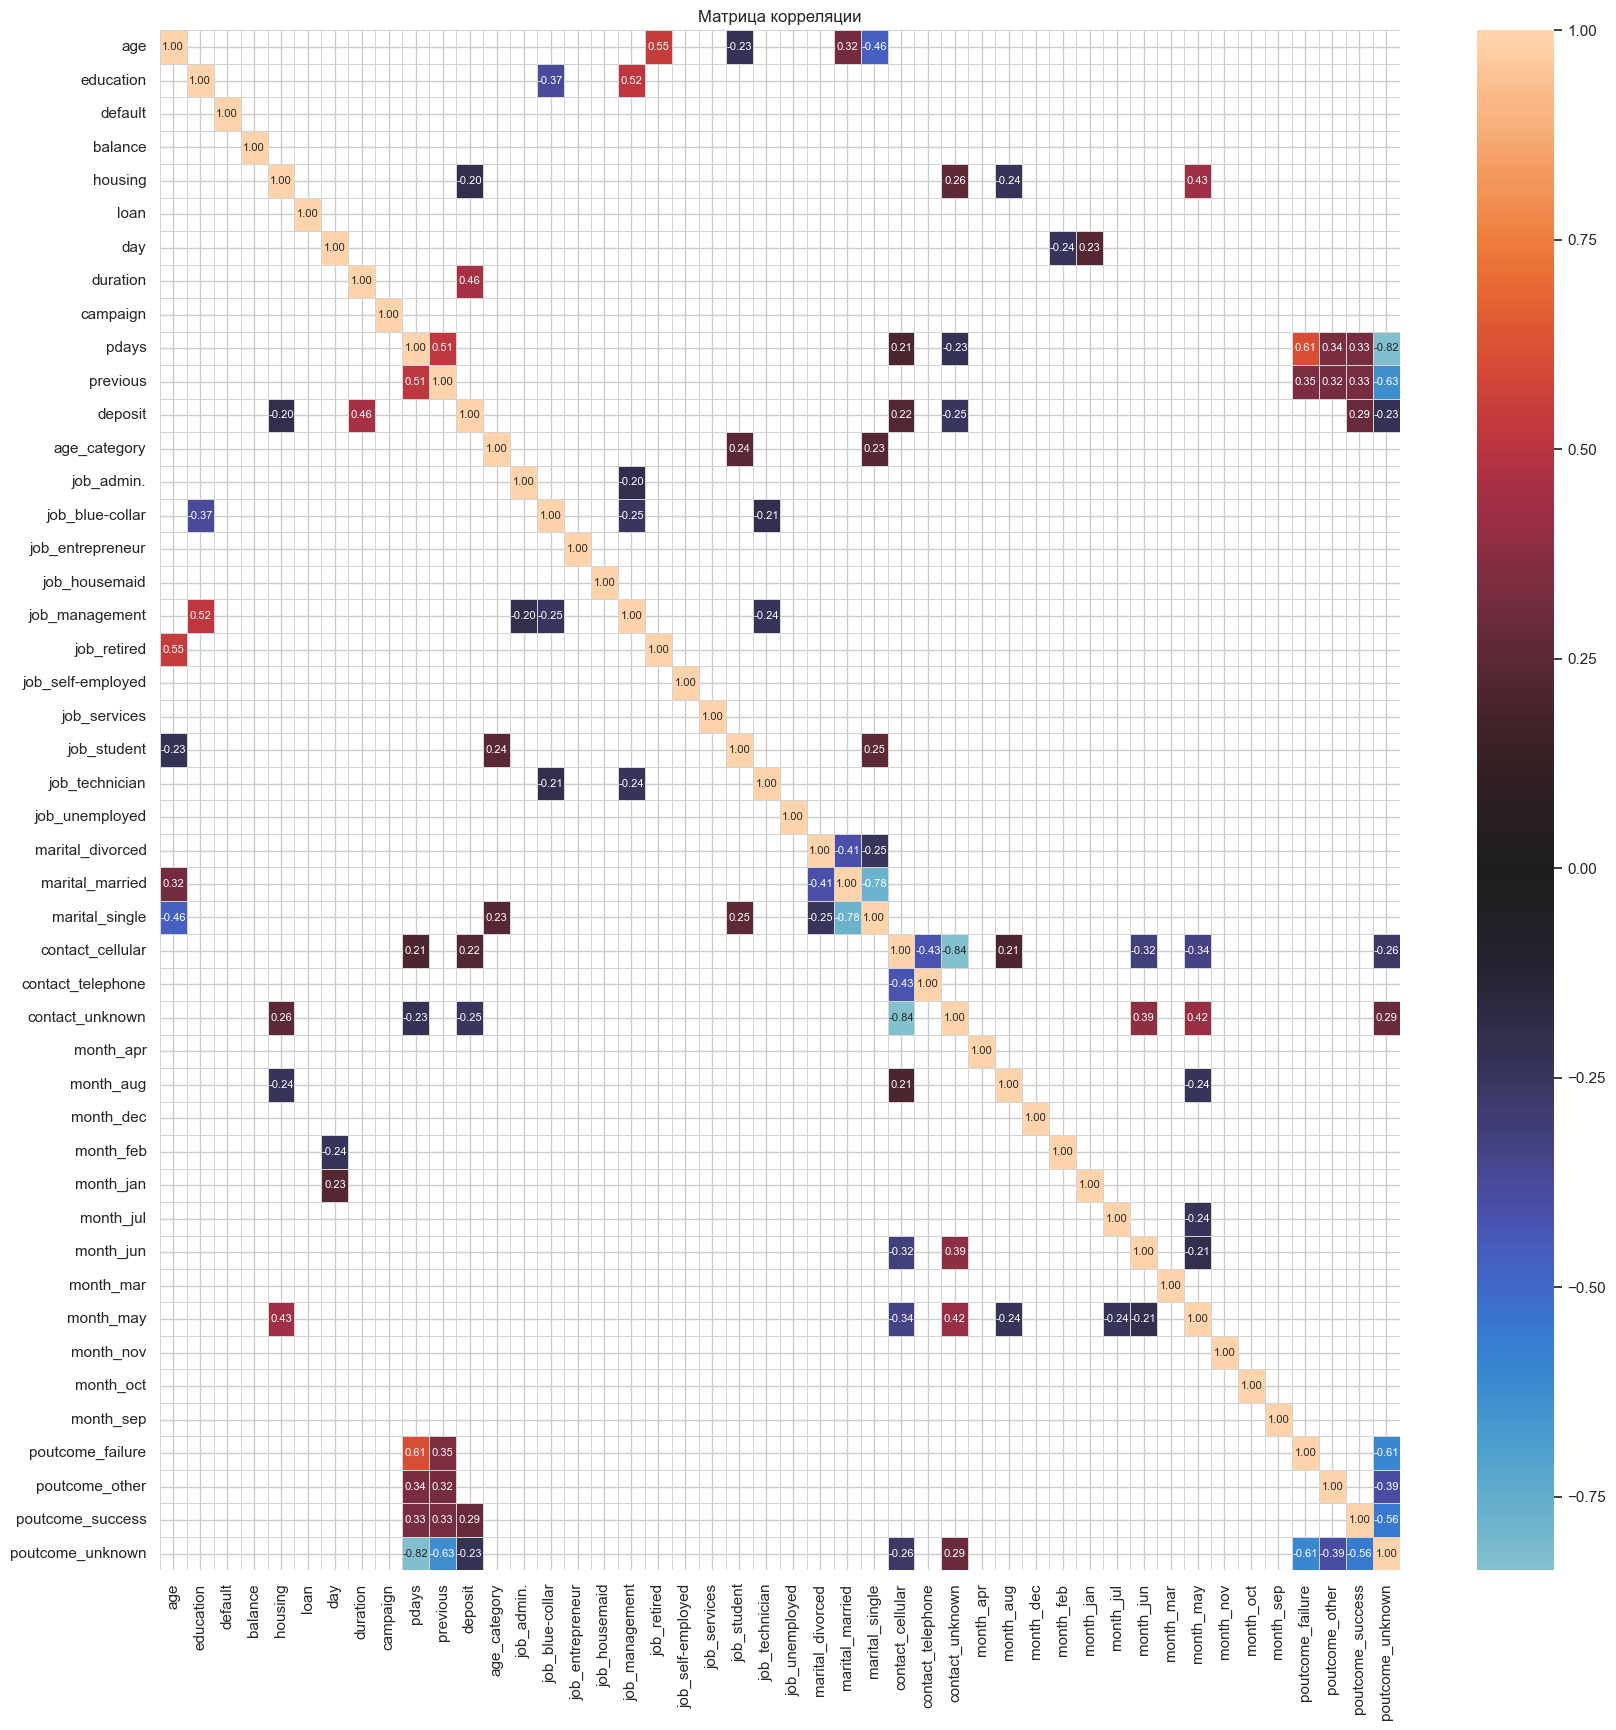

In [31]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
df_corr = df.corr()
mask_1 = abs(df_corr) < 0.2
fig = plt.figure(figsize=(20, 20))
fig = sns.heatmap(df_corr, annot=True, fmt='.2f', center=0, mask=mask_1,
                  linewidths=0.5, linecolor='lightgray', annot_kws={'size': 8})
fig.set_title('Матрица корреляции');

### Задания 7 и 8

In [32]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [33]:
# рассчитайте необходимые показатели
print(X_test.shape[0])
y_test.mean().round(2)

3335


0.46

### Задание 9

In [34]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

# Сохраняем названия фич
feature_names = selector.get_feature_names_out()
print(f"Selected features: {feature_names}")

Selected features: ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'age_category' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [35]:
# Преобразуем данные
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print(f"Train shape: {X_train_selected.shape}")
print(f"Test shape: {X_test_selected.shape}")

Train shape: (6770, 15)
Test shape: (3335, 15)


### Задание 10

In [36]:
# нормализуйте данные с помощью minmaxsxaler
scaler = MinMaxScaler()
scaler.fit(X_train_selected)
X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [37]:
X_test_scaled[:, 0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [38]:
# обучите логистическую регрессию и рассчитайте метрики качества
# Создаем объект класса логистическая регрессия
lr = linear_model.LogisticRegression(random_state=42, solver = 'sag', max_iter=1000)
# Обучаем модель
lr.fit(X_train_scaled, y_train)

# Делаем предсказание
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

# Вывод метрик
print('Accuracy на train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy на train: 0.82
Accuracy на test: 0.81


### Задания 2,3,4

In [39]:
# обучите решающие деревья, настройте максимальную глубину
# Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

# Обучаем дерево
dt.fit(X_train_scaled, y_train)

# Делаем предсказание
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

# Отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



### Задание 5

In [40]:
# подберите оптимальные параметры с помощью gridsearch
# Задаю параметры
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8]
}
# Создаем объект GridSearchCV для поиска по сетке
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42), 
    param_grid=param_grid, 
    cv=3,
    n_jobs = -1,
    verbose=1
)

# Обучаем модель с подбором гиперпараметров и замеряем время
grid_search.fit(X_train_scaled, y_train)
# Выводим результаты
print('Accuracy на тренировочной выборке: {:.2f}'.format(grid_search.score(X_train_scaled, y_train)))
print('Accuracy на тестовой выборке: {:.2f}'.format(grid_search.score(X_test_scaled, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Accuracy на тренировочной выборке: 0.84
Accuracy на тестовой выборке: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7}


In [41]:
param_grid_new = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_search_new = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid_new,
    cv=3,
    n_jobs=-1
)

grid_search_new.fit(X_train_scaled, y_train)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_new.best_params_))
y_test_pred_gs = grid_search.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred_gs))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.82      0.81      3335
weighted avg       0.82      0.81      0.82      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [42]:
# обучите на ваших данных случайный лес
# Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100, criterion = 'gini', min_samples_leaf = 5,
    max_depth = 10, random_state = 42)
# Обучаем модель
rf.fit(X_train_scaled, y_train)
# Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [43]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
).fit(X_train_scaled, y_train)

print(metrics.classification_report(y_test, gb.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [44]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [('lr', lr), ('dt', grid_search_new), ('gb', gb)]

stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(max_iter=1000, random_state=42)
)

stack.fit(X_train_scaled, y_train)
y_test_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

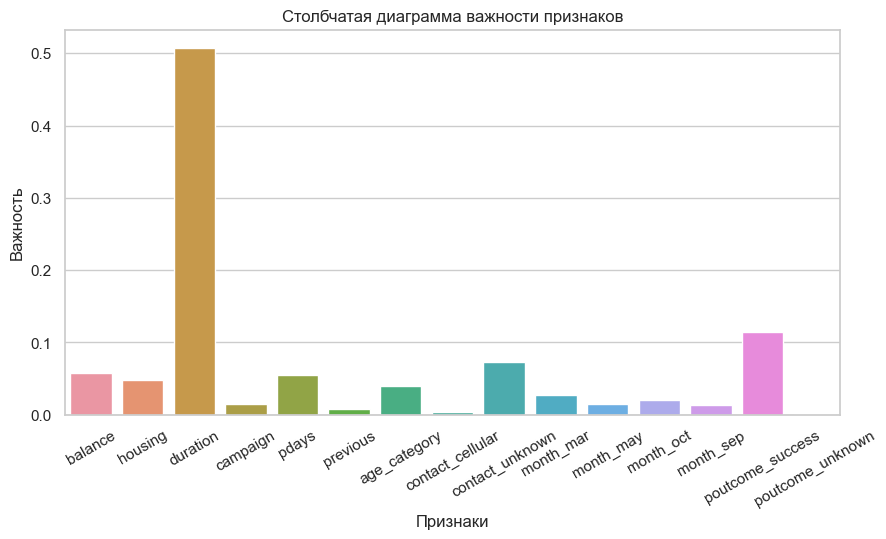

In [45]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

fig, ax = plt.subplots(figsize=(10, 5))
fig = sns.barplot(x=feature_names, y=gb.feature_importances_, ax=ax)
ax.set_title('Столбчатая диаграмма важности признаков')
ax.set_xlabel('Признаки')
ax.set_ylabel('Важность')
fig.xaxis.set_tick_params(rotation=30);

### Задания 6,7,8

In [46]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# Целевая функция для Optuna
def optuna_rf(trial, X=X_train_scaled, y=y_train, cv=5, scoring="accuracy"):
    # Задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10, 1)
    
    # Создаем модель
    model = ensemble.RandomForestClassifier(
        random_state=42,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf
)
    # Кросс-валидация сама обучит модель
    score = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1).mean()
    # Возвращает целевую метрику
    return score

In [47]:
# Cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-12-12 06:34:48,505] A new study created in memory with name: RandomForestClassifier
[I 2025-12-12 06:34:50,216] Trial 0 finished with value: 0.8358936484490398 and parameters: {'n_estimators': 102, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8358936484490398.
[I 2025-12-12 06:34:52,131] Trial 1 finished with value: 0.83205317577548 and parameters: {'n_estimators': 162, 'max_depth': 30, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8358936484490398.
[I 2025-12-12 06:34:54,070] Trial 2 finished with value: 0.8345642540620384 and parameters: {'n_estimators': 147, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8358936484490398.
[I 2025-12-12 06:34:56,756] Trial 3 finished with value: 0.8357459379615954 and parameters: {'n_estimators': 165, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8358936484490398.
[I 2025-12-12 06:34:58,574] Trial 4 finished with value: 0.8350073855243721 and parameters: {'n_e

In [48]:
# Обучаю модель на лучших параметрах, вывожу метрики
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

Наилучшие значения гиперпараметров {'n_estimators': 102, 'max_depth': 29, 'min_samples_leaf': 6}
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

